<a href="https://colab.research.google.com/github/runnithan03/Dissertation/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving final.csv to final.csv


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

seed = 42
np.random.seed(seed)

data = pd.read_csv('clean.csv')

# Frequency encode categorical variables
categorical_columns = ['rating', 'risk_rating', 'category']
for col in categorical_columns:
    freq_encoding = data[col].value_counts().to_dict()
    data[col] = data[col].map(freq_encoding)

# Define predictor and target variables
X = data.drop(columns=['roe', 'sustainability_score'])
y = data[['roe', 'sustainability_score']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=seed)

# MultiOutputRegressor handles multiple target variables
multi_output_model = MultiOutputRegressor(xgb_model)

# model fit and predictions
multi_output_model.fit(X_train, y_train)
y_pred = multi_output_model.predict(X_test)

# Evaluate the model using Root Squared Residual (RSR)
rsr = np.sqrt(np.mean((y_test - y_pred)**2, axis=0)) / np.std(y_test, axis=0)
average_rsr = np.mean(rsr)

print(f'Root Squared Residual (RSR) for each response: {rsr}')
print(f'Average RSR: {average_rsr}')

Root Squared Residual (RSR) for each response: roe                     0.313207
sustainability_score    0.461686
dtype: float64
Average RSR: 0.3874466169354688


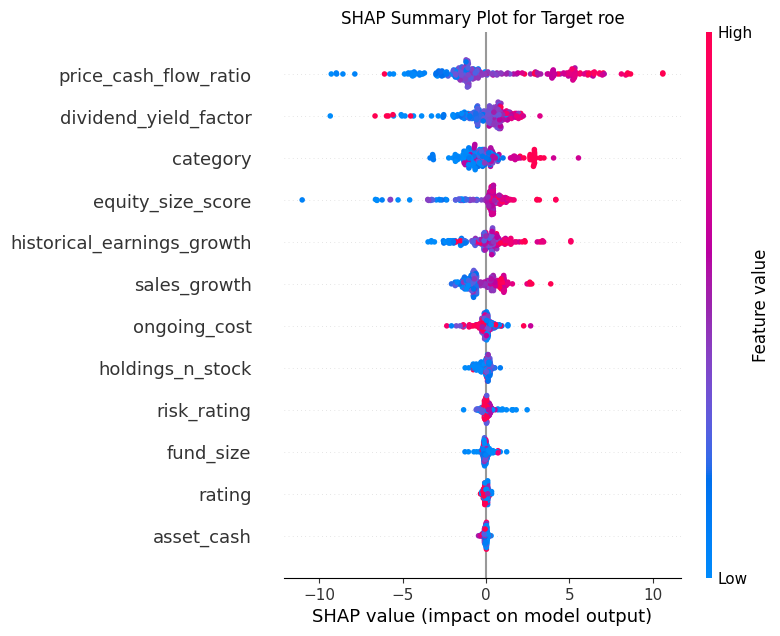

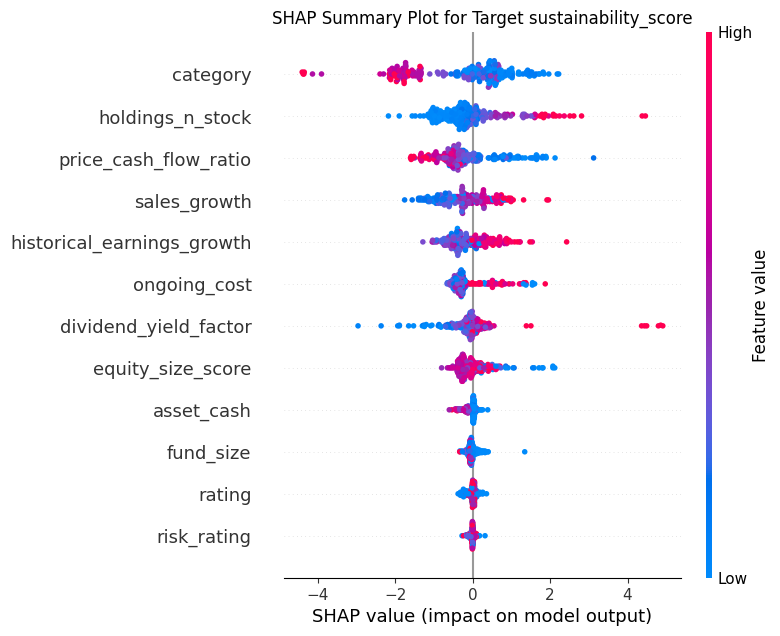

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer and SHAP values
for i, estimator in enumerate(multi_output_model.estimators_):
    explainer = shap.Explainer(estimator, X_train)
    shap_values = explainer(X_test)

    # Plot SHAP summary plot for each target
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f'SHAP Summary Plot for Target {y.columns[i]}')
    plt.show()

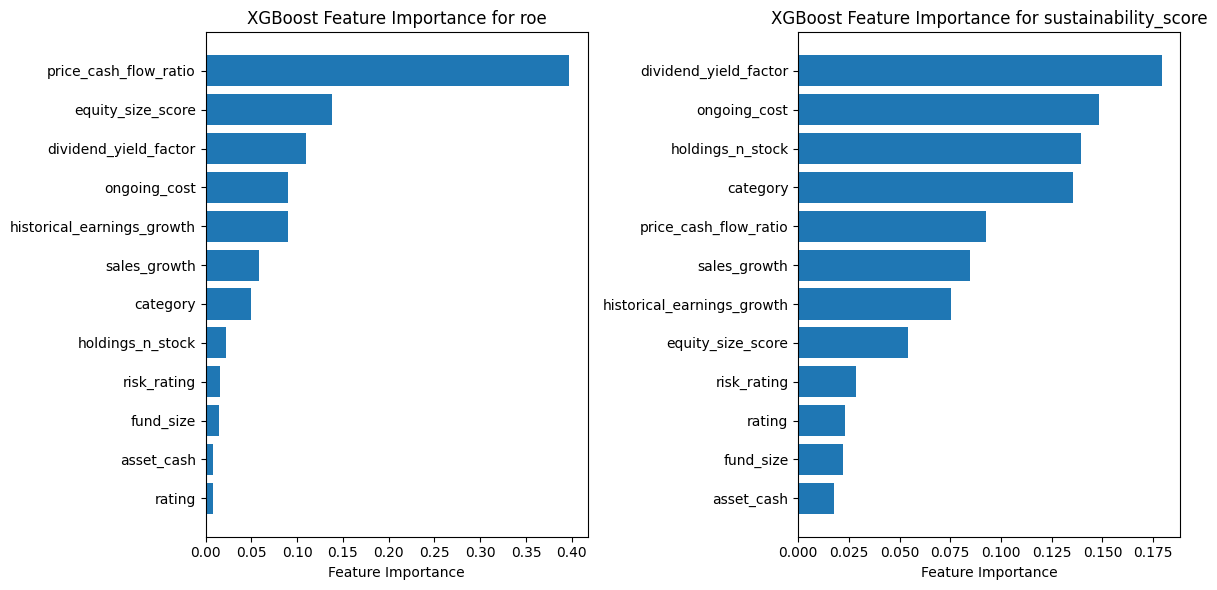

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, estimator in enumerate(multi_output_model.estimators_):
    feature_importance = estimator.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.subplot(1, 2, i + 1)
    plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'XGBoost Feature Importance for {y.columns[i]}')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the model with evaluation set
multi_output_model.fit(X_train, y_train,
                       eval_set=[(X_train, y_train), (X_test, y_test)])

# Save evaluation results for plotting
eval_results = [estimator.evals_result() for estimator in multi_output_model.estimators_]

# Calculate ARSR for each boosting round
arsr_train = []
arsr_test = []

# Loop through boosting rounds to compute ARSR at each step
for i in range(len(eval_results[0]['validation_0']['rmse'])):
    train_rmse = np.array([results['validation_0']['rmse'][i] for results in eval_results])
    test_rmse = np.array([results['validation_1']['rmse'][i] for results in eval_results])

    # Calculate ARSR (mean of RMSE for both targets)
    arsr_train.append(np.mean(train_rmse))
    arsr_test.append(np.mean(test_rmse))

# Plot ARSR for both responses
plt.figure(figsize=(10, 6))
plt.plot(arsr_train, label='Test ARSR')
plt.xlabel('Boosting Rounds')
plt.ylabel('ARSR')
plt.title('XGBoost ARSR Learning Curve for roe and sustainability_score')
plt.legend()
plt.show()

XGBoostError: [12:42:54] /workspace/src/objective/regression_obj.cu:50: Check failed: info.labels.Size() == preds.Size() (998 vs. 1996) : Invalid shape of labels.
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x7f85a122dcbc]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xc30292) [0x7f85a1c30292]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xc67d1f) [0x7f85a1c67d1f]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x5cb173) [0x7f85a15cb173]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7f85a113752f]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f85fffcae2e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f85fffc7493]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f85ffff03e9]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x7f85fffefa00]

